# Geospatial Matching Optimization

This project is designed to showcase how to improve the speed of a polygon matching procedure. There are two main areas that could benefit from taking a "geospatial-native" approach:

1. Data encoding, fetching, and storage
2. Matching

We will generate synthetic polygon data and use both a non-geospatial-native and geospatial-native approach, comparing execution time for both to see how they differ.

Note: Make sure that you have PostgreSQL running.

## Imports

In [91]:
import geopandas as gpd
import pandas as pd
import shapely
import h3
import time
import helpers as h
import matplotlib.pyplot as plt
from shapely.wkt import dumps, loads
from pathlib import Path

# ensure helpers is loaded correctly
import importlib
importlib.reload(h)

Created fresh logs/sid_2025-02-27_11-55-36_timing_results.csv
Created fresh logs/sid_2025-02-27_11-55-36_timing.log


<module 'helpers' from '/Users/sra/files/projects/matching_optimization/helpers.py'>

## Generate Test Data

In [231]:
# Create two months of blob data
prev_month_blobs = h.generate_random_polygons(n=10000)
curr_month_blobs = h.generate_random_polygons(n=10000)

Function `generate_random_polygons` executed in 0.2021 sec, CPU: 38.30%, Memory: 16.31MB
Function `generate_random_polygons` executed in 0.1218 sec, CPU: 28.70%, Memory: 2.70MB


In [194]:
prev_month_blobs.head()

,geometry,id
0,"POLYGON ((-67.77737 59.48422, -67.77737 60.922...",7f4dff84-d1b5-4f2c-bf65-77102679ed3b
1,"POLYGON ((26.42248 9.32281, 26.42248 11.29955,...",38dd1028-22a7-48a8-b549-b2b371a3fd64
2,"POLYGON ((34.53971 -70.83667, 34.53971 -69.101...",e228399c-7167-4951-84b6-6d7b28ef5979
3,"POLYGON ((173.13634 -65.81346, 173.13634 -64.1...",5db7eab1-eb05-4986-986b-e5686d582bea
4,"POLYGON ((135.94789 12.84035, 135.94789 14.170...",624b76ae-a2ac-45d5-b42e-688e897bec9b


In [195]:
curr_month_blobs.head()

,geometry,id
0,"POLYGON ((4.28622 46.11889, 4.28622 47.52923, ...",e09e5f03-4d65-4ac2-baee-0fe57e8f9291
1,"POLYGON ((-173.38761 -68.51772, -173.38761 -66...",1bbbfaac-489f-462a-a855-2cdd7498d016
2,"POLYGON ((-31.44297 15.05155, -31.44297 16.136...",021ecc97-941c-4213-b2c1-d000d8296be8
3,"POLYGON ((61.63457 -29.41362, 61.63457 -27.670...",2e815754-6f99-41ea-a35e-17e78855539a
4,"POLYGON ((109.58164 25.28846, 109.58164 26.892...",7eade105-5c06-49ff-b128-e7213142da05


In [196]:
# make data folder
Path('data/').mkdir(exist_ok=True)

# save as geoparquet
prev_month_blobs.to_parquet('data/prev_month_blobs.parquet')
curr_month_blobs.to_parquet('data/curr_month_blobs.parquet')

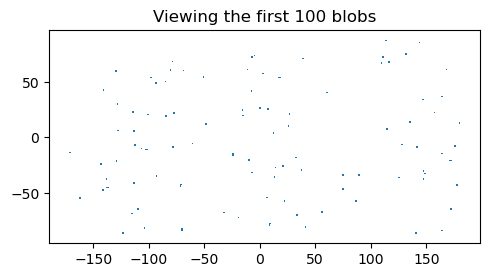

In [197]:
range_ = 100

fig, ax = plt.subplots(figsize=(5, 5))
prev_month_blobs.iloc[0:range_].plot(ax=ax)
ax.set_title(f'Viewing the first {range_} blobs')
plt.tight_layout()

plt.show()

## Non-optimized process

### 1. Data encoding, storage, and fetching

We will use PostgreSQL and string storage for geographic information.

#### Make copy of polygon layer and convert to non-geospatial-native string (WKT) datatype

In [198]:
# copy the gdfs
prev_month_blobs_wkt = prev_month_blobs.copy()
curr_month_blobs_wkt = curr_month_blobs.copy()

In [199]:
# Convert WKT versions to strings
dfs_to_convert = [prev_month_blobs_wkt, curr_month_blobs_wkt]
prev_month_blobs_wkt, curr_month_blobs_wkt = [h.convert_col_to_string(df) for df in dfs_to_convert]

# Check result
print(prev_month_blobs_wkt.head())

Function `convert_col_to_string` executed in 0.0471 sec, CPU: 13.50%, Memory: 0.00MB
Function `convert_col_to_string` executed in 0.0461 sec, CPU: 23.70%, Memory: 0.00MB
                                            geometry  \
0  POLYGON ((-67.777368 59.484217, -67.777368 60....   
1  POLYGON ((26.422479 9.322808, 26.422479 11.299...   
2  POLYGON ((34.539713 -70.836672, 34.539713 -69....   
3  POLYGON ((173.136338 -65.813461, 173.136338 -6...   
4  POLYGON ((135.94789 12.840354, 135.94789 14.17...   

                                     id  
0  7f4dff84-d1b5-4f2c-bf65-77102679ed3b  
1  38dd1028-22a7-48a8-b549-b2b371a3fd64  
2  e228399c-7167-4951-84b6-6d7b28ef5979  
3  5db7eab1-eb05-4986-986b-e5686d582bea  
4  624b76ae-a2ac-45d5-b42e-688e897bec9b  


/Users/sra/files/projects/matching_optimization/helpers.py:148: UserWarning: Geometry column does not contain geometry.
  def df_itertuple(df: gpd.GeoDataFrame):
/Users/sra/files/projects/matching_optimization/helpers.py:148: UserWarning: Geometry column does not contain geometry.
  def df_itertuple(df: gpd.GeoDataFrame):


### Save in PostgreSQL database

This is a simple version of what a "non-geospatial-native" data ingestion pipeline may look like, with the primary example being that the polygons are stored as strings, not in a spatial-friendly datatype.

In [200]:
# Convert to tuples
prev_month_blobs_wkt = h.df_itertuple(prev_month_blobs_wkt)
curr_month_blobs_wkt = h.df_itertuple(curr_month_blobs_wkt)

Function `df_itertuple` executed in 0.0019 sec, CPU: 0.00%, Memory: 0.00MB
Function `df_itertuple` executed in 0.0012 sec, CPU: 0.00%, Memory: 0.00MB


Create PostgreSQL database if it doesn't exist already. We will be using the default settings. If they need to be adjusted, refer to [`helpers.py`](helpers.py).

In [201]:
h.create_pg_db()

Database blob_matching already exists.
Function `create_pg_db` executed in 0.0308 sec, CPU: 0.00%, Memory: 0.00MB


Create and insert into tables:

In [202]:
h.create_pg_table(table_name='prev_blobs_wkt', data=prev_month_blobs_wkt, truncate=True)
h.create_pg_table(table_name='curr_blobs_wkt', data=curr_month_blobs_wkt, truncate=True)

Table prev_blobs_wkt truncated.
Inserted 10000 records into prev_blobs_wkt.
Function `create_pg_table` executed in 0.3939 sec, CPU: 0.00%, Memory: 0.00MB
Table curr_blobs_wkt truncated.
Inserted 10000 records into curr_blobs_wkt.
Function `create_pg_table` executed in 0.4047 sec, CPU: 41.30%, Memory: 126.31MB


Retrieve data as GeoDataFrames to confirm that it worked:

In [203]:
df_prev = h.retrieve_pg_table(table_name='prev_blobs_wkt')
df_curr = h.retrieve_pg_table(table_name='curr_blobs_wkt')

Retrieved 10000 records from prev_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0471 sec, CPU: 29.40%, Memory: 0.00MB
Retrieved 10000 records from curr_blobs_wkt.
Function `retrieve_pg_table` executed in 0.0404 sec, CPU: 9.00%, Memory: 0.00MB


Compare the tables before and after for a sanity check:

In [204]:
df_prev.head()

,geometry,id
0,"POLYGON ((-67.777368 59.484217, -67.777368 60....",7f4dff84-d1b5-4f2c-bf65-77102679ed3b
1,"POLYGON ((26.422479 9.322808, 26.422479 11.299...",38dd1028-22a7-48a8-b549-b2b371a3fd64
2,"POLYGON ((34.539713 -70.836672, 34.539713 -69....",e228399c-7167-4951-84b6-6d7b28ef5979
3,"POLYGON ((173.136338 -65.813461, 173.136338 -6...",5db7eab1-eb05-4986-986b-e5686d582bea
4,"POLYGON ((135.94789 12.840354, 135.94789 14.17...",624b76ae-a2ac-45d5-b42e-688e897bec9b


In [209]:
prev_month_blobs.head()

,geometry,id
0,"POLYGON ((-67.77737 59.48422, -67.77737 60.922...",7f4dff84-d1b5-4f2c-bf65-77102679ed3b
1,"POLYGON ((26.42248 9.32281, 26.42248 11.29955,...",38dd1028-22a7-48a8-b549-b2b371a3fd64
2,"POLYGON ((34.53971 -70.83667, 34.53971 -69.101...",e228399c-7167-4951-84b6-6d7b28ef5979
3,"POLYGON ((173.13634 -65.81346, 173.13634 -64.1...",5db7eab1-eb05-4986-986b-e5686d582bea
4,"POLYGON ((135.94789 12.84035, 135.94789 14.170...",624b76ae-a2ac-45d5-b42e-688e897bec9b


In [211]:
def round_geometry(geom, precision=6):
    """Round all coordinates of a geometry to a given precision."""
    return shapely.wkt.loads(shapely.wkt.dumps(geom, rounding_precision=precision))

# Convert both to sets of rounded WKT strings
set_prev_month_blobs = set(prev_month_blobs['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))
set_df_prev = set(df_prev['geometry'].apply(lambda g: round_geometry(g, precision=6).wkt))

# Find common, missing, and extra geometries
common_geometries = set_prev_month_blobs & set_df_prev
missing_from_retrieved = set_prev_month_blobs - set_df_prev
extra_in_retrieved = set_df_prev - set_prev_month_blobs

# Print summary
print(f"Number of matching geometries: {len(common_geometries)}")
print(f"Missing geometries in retrieved table: {len(missing_from_retrieved)}")
print(f"Extra geometries in retrieved table: {len(extra_in_retrieved)}")

# Show an example missing/extra geometry for debugging
if missing_from_retrieved:
    print("Example missing record:", next(iter(missing_from_retrieved)))

if extra_in_retrieved:
    print("Example extra record:", next(iter(extra_in_retrieved)))

Number of matching geometries: 10000
Missing geometries in retrieved table: 0
Extra geometries in retrieved table: 0


### 2. Matching

We will match the polygons using GeoPandas.

Baseline - Polygon Matching Only

geohash polygon into a larger region
match blobs using multiprocessing (mp.Process) and geopandas
find blobs from previous month that do not have a match

# 1 imports and setup

```python
import os, sys, traceback
import argparse
import cv2
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io, color, measure
from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import PIL
from PIL import Image, ImageDraw, ImageEnhance
import uuid
import multiprocessing as mp
from datetime import datetime
from sqlalchemy import or_
from sqlmodel import SQLModel, Session, create_engine, select
from pathlib import Path
```

## Key takeaways
- Uses Pandas and GeoPandas for data processing.
- Uses Shapely for geospatial geometry operations.
- Uses multiprocessing (mp) to parallelize the blob-matching process.
- Uses SQLAlchemy and SQLModel for database operations.

# 2 High-level script overview
The script is designed to match blobs (spatial objects) between two months and classify them into different business categories.

General Workflow
1. Fetch blobs from the previous and current months.
1. Convert the region of interest (state, city, county, or geohash) into a list of geohashes.
1. Parallelized Matching Process:
1. Process multiple geohashes at once using multiprocessing.
1. Find corresponding blobs from previous months for each geohash.
1. Classify blobs based on construction stage progression.
1. Identify blobs that are missing in the current month and "impute" them.
1. Save results into the database.

# 3 Blob classification logic

# 4 Blob matching

- Matches blobs between months using polygon intersections.
- Uses Shapely to validate geometries and check for overlaps.
- Returns matched blob IDs.

## Multiprocessing Optimization
The script parallelizes blob matching by:
- Uses multiprocessing (mp.Process) to divide the dataset into smaller batches.
- Each batch of blobs is processed in parallel.
- Reduces runtime compared to a single-threaded approach.

# 5 Handling unmatched blobs
- Finds blobs from the previous month that do not have a match in the current month.
- These blobs are "imputed", meaning they are carried over into the new month.

# 6 Main class to orchestrate process
- Loads previous and current month blobs.
- Converts input regions (state, city, county) into geohashes.

# Summary
- Parallel processing is used to match blobs.
- Blobs are classified based on construction stages.
- Unmatched blobs are imputed for continuity.
- The script writes results to a database.